In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D,AlphaDropout,SeparableConv2D, SpatialDropout2D, MaxPooling2D
from tensorflow.keras import regularizers
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
#Loading Labels
traindf = pd.read_excel('/content/drive/My Drive/Paper/UTKFace/traindf.xlsx')
valdf = pd.read_excel('/content/drive/My Drive/Paper/UTKFace/valdf.xlsx')
testdf = pd.read_excel('/content/drive/My Drive/Paper/UTKFace/testdf.xlsx')
traindf.head()

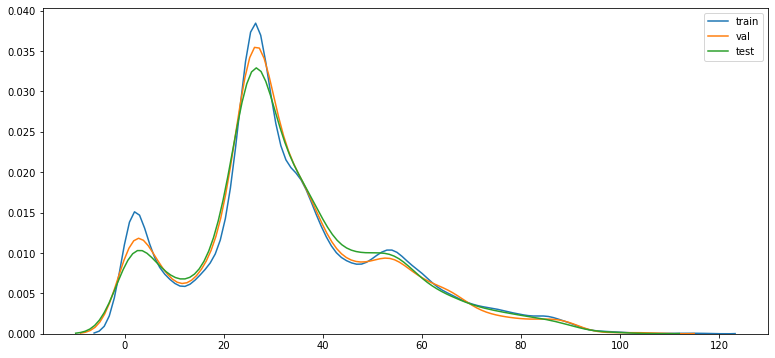

In [ ]:
import seaborn as sns

plt.figure(figsize=(13,6))
sns.kdeplot(traindf['age'], label='train', gridsize=100)
sns.kdeplot(valdf['age'], label='val',  gridsize=100)
sns.kdeplot(testdf['age'], label='test', gridsize=100)
plt.show();

In [ ]:
#Loading Features Extracted using ResNet50

fx_train_res= np.load('/content/drive/My Drive/Paper/UTKFace/fx_train_res.npy')
fx_val_res = np.load('/content/drive/My Drive/Paper/UTKFace/fx_val_res.npy')
fx_test_res = np.load('/content/drive/My Drive/Paper/UTKFace/fx_test_res.npy')
print("Loaded!")

Loaded!


In [ ]:
x_train= np.load('/content/drive/My Drive/Paper/UTKFace/x_train.npy')
x_val = np.load('/content/drive/My Drive/Paper/UTKFace/x_val.npy')
x_test = np.load('/content/drive/My Drive/Paper/UTKFace/x_test.npy')

Age Estimation Model

In [ ]:
print('Train : '+str(fx_train_res.shape))
print('Val : '+str(fx_val_res.shape))
print('Test : '+str(fx_test_res.shape))

Train : (18961, 1, 1, 2048)
Val : (2370, 1, 1, 2048)
Test : (2371, 1, 1, 2048)


In [ ]:
model = Sequential()

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512,activation='selu',kernel_initializer='lecun_normal'))

model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(512,activation='selu',kernel_initializer='lecun_normal'))

model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(512,activation='selu',kernel_initializer='lecun_normal'))

model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(256,activation='selu',kernel_initializer='lecun_normal'))

model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128,activation='selu',kernel_initializer='lecun_normal'))

model.add(BatchNormalization())
model.add(Dense(1,activation='relu',kernel_initializer='he_uniform'))

In [ ]:
sgd = tf.keras.optimizers.SGD(
    learning_rate=1e-2, momentum=0, nesterov=False, name="SGD")

adam = tf.keras.optimizers.Adam(
    learning_rate=1e-3,
    amsgrad=True,)

adamax = tf.keras.optimizers.Adamax(learning_rate=1e-4)

model.compile(optimizer=adam,loss='mse',metrics=['mae'])

In [ ]:
model.fit(fx_train_res,traindf['age'].values ,epochs=20, validation_data=(fx_val_res,valdf['age'].values),batch_size=256)

In [ ]:
model.evaluate(fx_test_res,testdf['age'].values)

In [ ]:
model.save('/content/drive/My Drive/Paper/UTKFace/Age Estimation/model.h5')

In [ ]:
model.predict(fx_test_vgg).shape

Ensemble

In [ ]:
from keras.models import load_model

G_res = load_model('/content/drive/My Drive/Paper/UTKFace/Gender/ResNet50/9464.h5')
G_res.compile("Adam","binary_crossentropy",['acc'])

G_sen = load_model('/content/drive/My Drive/Paper/UTKFace/Gender/SeNet50/9494.h5')
G_sen.compile("Adam","binary_crossentropy",['acc'])

G_vgg = load_model('/content/drive/My Drive/Paper/UTKFace/Gender/VGG16/9367.h5')
G_vgg.compile("Adam","binary_crossentropy",['acc'])

In [ ]:
fx_test_res_e = np.load('/content/drive/My Drive/Paper/UTKFace/fx_test_res.npy')
fx_test_sen_e = np.load('/content/drive/My Drive/Paper/UTKFace/fx_test_sen.npy')
fx_test_vgg_e = np.load('/content/drive/My Drive/Paper/UTKFace/fx_test_vgg.npy')

In [ ]:
pred_res = G_res.predict(fx_test_res_e)
pred_sen = G_sen.predict(fx_test_sen_e)
pred_vgg = G_vgg.predict(fx_test_vgg_e)

In [ ]:
pred_res.shape, pred_sen.shape, pred_vgg.shape

In [ ]:
pred_res[:5]

In [ ]:
pred_sen[:5]

In [ ]:
pred_vgg[:5]

In [ ]:
y_pred = (pred_res+pred_sen+pred_vgg)/3

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(testdf['gender'].values,y_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1234
           1       0.95      0.94      0.95      1137

    accuracy                           0.95      2371
   macro avg       0.95      0.95      0.95      2371
weighted avg       0.95      0.95      0.95      2371



In [ ]:
from sklearn.metrics import roc_auc_score

auc_vgg = roc_auc_score(testdf['gender'].values,pred_vgg.round())
auc_res = roc_auc_score(testdf['gender'].values,pred_res.round())
auc_sen = roc_auc_score(testdf['gender'].values,pred_sen.round())
auc_en = roc_auc_score(testdf['gender'].values,y_pred.round())
print('ROC_AUC_SCORE : \n')
print('ResNet50: ',auc_res)
print('SeNet50: ',auc_sen)
print('VGG16: ',auc_vgg)
print('Ensemble: ',auc_en)

ROC_AUC_SCORE : 

ResNet50:  0.9465709899376933
SeNet50:  0.9491653231726701
VGG16:  0.9361109804441441
Ensemble:  0.9477423599024417


In [ ]:
from sklearn.metrics import accuracy_score 

acc_vgg = accuracy_score(testdf['gender'].values,pred_vgg.round())
acc_res = accuracy_score(testdf['gender'].values,pred_res.round())
acc_sen = accuracy_score(testdf['gender'].values,pred_sen.round())
acc_en = accuracy_score(testdf['gender'].values,y_pred.round())
print('ACCURACY_SCORE : \n')
print('ResNet50: ',acc_res)
print('SeNet50: ',acc_sen)
print('VGG16: ',acc_vgg)
print('Ensemble: ',acc_en)

ACCURACY_SCORE : 

ResNet50:  0.9464361029101644
SeNet50:  0.9493884436946436
VGG16:  0.9367355546183045
Ensemble:  0.9481231547870097
